Malaria Detektering

Denne journaler baseret på National Institute of Healths (NIH) officielle Malaria dataset:
https://ceb.nlm.nih.gov/repositories/malaria-datasets/. 

Datasettet indeholder 27.558 billeder af celler, hvoraf halvdelen er sunde celler og den anden halvdel er smittede celler. Vi fandt dette dataset på Kaggle, hvor vi valgte dette og besluttede os for, at bygge en form for Malaria detektering der kan skelne mellem sunde og smittede celler.


Step by step (HOML, chapter 2):
- Get the data
- Create a test set
- Discover and visualize the data to gain insight
- Prepare the data for machine learning algorithms
- Select and train a model
- Fine-tune your model


In [1]:
# Imports and from
import os
import cv2
import pandas as pd
import numpy as np
import keras

from pylab import *
from PIL import Image

from keras.utils import np_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K
from keras import optimizers

#For GPU cluster
from libitmal import kernelfuns as itmalkernelfuns
itmalkernelfuns.EnableGPU()

print('ok')


Using TensorFlow backend.


ok


In [ ]:
# Downloading and extracting.
# Only on first run
!wget = https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip 
!unzip cell_images.zip

In [ ]:
Vi har nu downloaded og udpakket datasettet og fortsætter nu med at definere deres path i to variabler.

In [2]:
#parasitized_data = os.listdir('/home/itmalgrp04/cell_images/Parasitized')
#uninfected_data = os.listdir('/home/itmalgrp04/cell_images/Uninfected')

parasitized_data = os.listdir('/Users/oscarp/Documents/Malaria_J3/cell_images/Parasitized')
uninfected_data = os.listdir('/Users/oscarp/Documents/Malaria_J3/cell_images/Uninfected')



For at bedre forstå forskellen mellem sunde (Uninfected) og smittede (Parasitized) celler, vil vi plotte 10 af billeder, hhv. 5 Uninfected og 5 Parasitized celler.

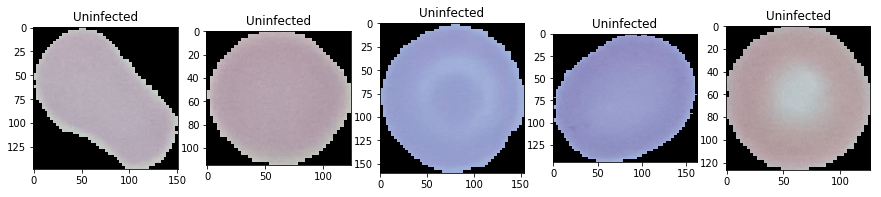

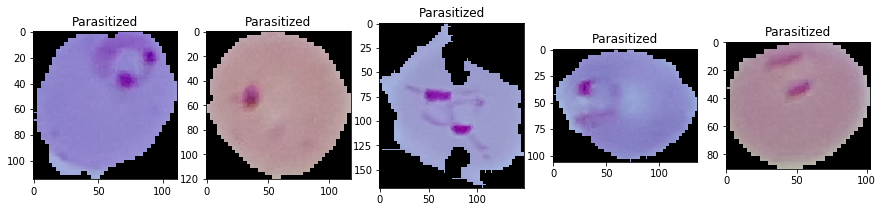

In [3]:
plt.figure(figsize = (15,15))
# Loop to plot 5 images of uninfected cells
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread('/Users/oscarp/Documents/Malaria_J3/cell_images/Uninfected' + "/" + uninfected_data[i+1])
    plt.title('Uninfected')
    plt.imshow(img)
plt.show()

plt.figure(figsize = (15,15))
# Loop to plot 5 images of infected cells
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread('/Users/oscarp/Documents/Malaria_J3/cell_images/Parasitized' + "/" + parasitized_data[i])
    plt.title('Parasitized')
    plt.imshow(img)
plt.show()

Kigger vi efter på plottene ovenover er det tydeligt at se, at billederne ikke skalerer på samme måde. Dette kunne ende ud i problemer senere. For at fikse dette, skal alle billederne skaleres på præcis samme måde. Næste punkt er derfor "Data Preparation". 

Her vil vi oprette data og labels lister. Data listen vil blive brugt til at indeholde de nyligt image_to_array konverterede billeder. Labels listen vil indeholde hhv 0 og 1 for de to klasser (Parasitized og Uninfected).

In [4]:
data = []
labels = []
for img in parasitized_data:
    try:
        # Indlæser billede
        img_read = plt.imread('/Users/oscarp/Documents/Malaria_J3/cell_images/Parasitized' + "/" + img)
        # Tilpasser størrelsen efter egne specifikationer
        img_resize = cv2.resize(img_read, (50, 50))
        # Konverterer et PIL image til et Numpy array
        img_array = img_to_array(img_resize)
        # Adder til data listen
        data.append(img_array)
        # Adder til labels listen. Værdi 1 når Parasitized. I næste section er det værdien0, når Uninfected
        labels.append(1)
    except:
        None
        
        # Gentages for de sunde celler
for img in uninfected_data:
    try:
        img_read = plt.imread('/Users/oscarp/Documents/Malaria_J3/cell_images/Uninfected' + "/" + img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

In [5]:
# Assigner array med data og labels til nye variabler
Cells = np.array(data)
Labels = np.array(labels)

In [6]:
# Får dimensionerne af arrayet og blander dem.
a = np.arange(Cells.shape[0])
np.random.shuffle(a)
Cells = Cells[a]
Labels = Labels[a]

Et dataset på 27.558 billeder er i et sådant tilfælde, ikke særligt stort. Data augmentation (øge mængden af data), kunne derfor være spændende at lege med. Udover at data augmentation er oplagt at bruge når man har en forholdsvis lille datamængde, forhindrer det desuden modellen i at se det præcis samme billede flere gange.
I første omgang fortsætter vi dog uden, for at senere implementere det og forhåbentligt påvise en positiv forskel.

I nedenstående afsnit påbegynder vi et Train/test split af vores dataset på 20%. 

In [7]:
# Train/test split på 20% og med random_state parameter
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Cells, Labels, test_size = 0.2, random_state = 101)

Da vores classifier har flere klasser (N=2), vil det sidste output lag i vore Neurale netværk have to neuroner, en for hver klasse. Her vil One Hot Encoding hjælpe os med, at ændre vores labels i binær format. 

Dette kunne også gøres i vores data augmentation, ved at sætte class_mode til "categorical", men i første omgang prøver vi som sagt uden data augmentation.

In [8]:
# One Hot Encoding på både vores train og test set.
y_train = np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)

# Print for overblik
print("Training data:",x_train.shape, "Training labels:", y_train.shape)
print("Test data:", x_test.shape, "Test labels:", y_test.shape)


Training data: (22046, 50, 50, 3) Training labels: (22046, 2)
Test data: (5512, 50, 50, 3) Test labels: (5512, 2)


Af ovenstående print kan vi konkludere, at vi med success har fået oprettet et Train/test med 20%. 
Output at printet skal forstås på følgende måde:

Training data: (22046, 50, 50, 3)
- Det første tal er antallet af billeder.
- Det andet og tredje tal er length og width på billedet. Dette definerede vi højere oppe da vi preparerede vores data
- Det fjerde og sidste tal er 3, og er dette da vi har et 3-kanals RGB billede

Training labels: (22046, 2)
- Det første tal er igen antallet af billeder.
- Det sidste tal er antallet af klasser: Parasitized & Uninfected

# CNN Model

Næste step vil nu være at bygge vores Convolutional Neural Network (CNN) model. CNN er i særdeleshed kendetegnet ved at være fordelagtigt at bruge til billedgenkendelse, billed klassifikation og lignende. En CNN klassifikations model som denne vi gerne vil bygge, fungerer ved, at tage et input billede, processere det og klassificere det i en bestemt kategori (Parasitized eller Uninfected). Helt konkret bliver hvert billede sendt igennem en række Convolution layers med diverse filtre, en form for Pooling og til sidst tilføjer vi en Softmax funktion til at klassificere et billede med en værdi mellem 0 og 1.

Kigger vi nedenstående block, ses vores CNN model.
Her køres der med tre Convulution layers (Conv2D). 
- Den første parameter er antallet af filtre, der stiger i takt med dybden af netværket. Vores tre Conv2D lag er derfor med 16, 32 og 64 filtre.
- Det andet parameter siger noget om størrelser af disse convolution filtre. en kernel_size på 2 er her lig med 2x2.
- Den næste parameter er padding="same", der bibeholder vores spatiale volume, forstået på måde, at vores output størrelse matcher vores input størrelse. 
- Som activation funktionfaldt valget på reLU (Rectified Linear Unit). - - Den sidste parameter i vores første lag er simpelthen bare (width, height, channels).

Efter hvert Conv2D lag, tilføjer vi en MaxPooling2D funktion. Dette gøres for at down-sample, og derved bliver output mindre end input. At vi har valgt MaxPooling from for f.eks. AveragePooling betyder helt konkret, at vi i det 2D input vindue vælger de maksimale værdier til at være vores output.

Vi tilføjer nu et Dropout lag for at forebygge overfitting. Dette gøres ofte hvis netværket er for stort, hvis man træner for længe eller evt. ikke har nok data.

Da vi gerne vil benytte denne data i et neuralt netværk, flader vi dataen ud fra et map til en kolonne. Kort: Transformerer fra 2D arrays til en lan

Der følger nu en række dense og dropout lag der fungerer som vores fully-connected layers. I sidste lag benyttes der activation="softmax", idet vi gerne vil have outputtet en probability på mellem 0 og 1. Som tidligere nævnt, er Softmax derfor helt oplagt til multi-klassifikation.


In [21]:
#CNN model uden data augmentation
# https://keras.io/layers/convolutional/

#Testing with different filter size. Default: 16, 32, 64
# Leg rundt med enhederne

model=Sequential()

model.add(Conv2D(filters=16,
                 kernel_size=2,
                 padding="same",
                 activation="relu",
                 input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32,
                 kernel_size=2,
                 padding="same",
                 activation="relu"))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64,
                 kernel_size=2,
                 padding="same",
                 activation="relu"))
model.add(MaxPooling2D(pool_size=2))

#Tester med dropout på 0.5. Default: 0.2
#Tester med Dense på 600. Default: 500

# For at undgå overfitting
model.add(Dropout(0.5))
# Flader ud så kan benyttes senere
model.add(Flatten())
model.add(Dense(600,activation="relu"))
model.add(Dropout(0.5))

# Softmax var det naturlige valg, da vi har mere end én klasse af klassificere, hvor sigmoid måske
# er mere rettet mod binære. 2 er outpay layer neuroner

model.add(Dense(2,activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 25, 25, 32)        2080      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 6, 6, 64)          0         
__________

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
#fit the model onto the dataset
model.fit(x_train,y_train,batch_size=50,epochs=20,verbose=1)

Epoch 1/20
22046/22046 [==============================] - 32s 1ms/step - loss: 0.4224 - acc: 0.7981
Epoch 2/20
22046/22046 [==============================] - 32s 1ms/step - loss: 0.1611 - acc: 0.9478
Epoch 3/20
22046/22046 [==============================] - 30s 1ms/step - loss: 0.1482 - acc: 0.9528
Epoch 4/20
22046/22046 [==============================] - 30s 1ms/step - loss: 0.1440 - acc: 0.9543
Epoch 5/20
22046/22046 [==============================] - 31s 1ms/step - loss: 0.1355 - acc: 0.9563
Epoch 6/20
22046/22046 [==============================] - 33s 1ms/step - loss: 0.1347 - acc: 0.9568
Epoch 7/20
22046/22046 [==============================] - 30s 1ms/step - loss: 0.1274 - acc: 0.9584
Epoch 8/20
22046/22046 [==============================] - 29s 1ms/step - loss: 0.1241 - acc: 0.9584
Epoch 9/20
22046/22046 [==============================] - 31s 1ms/step - loss: 0.1214 - acc: 0.9590
Epoch 10/20
22046/22046 [==============================] - 31s 1ms/step - loss: 0.1188 - acc: 0.9606

In [ ]:
plt.figure(figsize = (15,5))
plt.title('Training Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel("Epochs")

plt.plot(range(20), model.history['loss'], label = 'Taining Loss')
plt.plot(range(20), model.history['acc'], label = 'Training Accuracy')

In [ ]:
#evaluate the model on test data
evaluation = model.evaluate(x_test, y_test)
print(f'Accuracy: {evaluation[1]} Loss: {evaluation[0]}')

27558 images isnt alot of data to train a model, so data augmentation might help

In [ ]:
#Refactor
# https://www.kaggle.com/gimunu/data-augmentation-with-keras-into-cnn
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = .15,
                                  height_shift_range = .15,
                                  fill_mode = 'nearest',
                                  zoom_range = 0.1,
                                  rotation_range = 15)
val_datagen = ImageDataGenerator(rescale = 1/255.)

train_generator = train_datagen.flow(x_train, y_train, batch_size = 64, shuffle = False)
val_generator = val_datagen.flow(x_test, y_test, batch_size = 64, shuffle = False)


In [ ]:
#refactor

#calling the same model as above
model_aug = CNNbuild(height = height, width = width, classes = classes, channels = channels)

In [ ]:
#Refactor

#compile the model
optim = optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
model_aug.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

In [ ]:
#Refactor
#fit the model on the augmented dataset
h_aug = model_aug.fit_generator(train_generator, steps_per_epoch = len(x_train) // 64, epochs = 50)

In [ ]:
#refactor
#evaluate the model on augmented test data
predict = model_aug.evaluate_generator(val_generator, steps = 5)

In [ ]:
#Refactor
print(f'LOSS ON TEST DATA AFTER DATA AUGMENTATION : {predict[0]}')
print(f'ACCURACY ON TEST DATA AFTER DATA AUGMENTATION : {predict[1]}')